In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.vision import *
import pandas as pd

In [3]:
df=pd.read_csv('./ori.csv')

In [4]:
df.head()

,patientid,healthassessmentid,assessment_date,n_assessment,assessment_number,final_assessment,assessment_year,assessment_type,assessment_quarter,assessment_month,...,imd_idaopi_score,glucose,tot_cholesterol,alcohol_consumption,regular_exercise,t2dm_nice,prediabetic,first_to_last,days_between_ha,years_between_ha
0,0x0001EC929E1AB41684A7B5528628E4B7,0x97B5EB4313702E21828DD59E5BC4F085,13oct2017,1,1,1,2017,1,4,10,...,0.024,3.8,4.68,1,0,0,0,NaN,NaN,NaN
1,0x0004022CC26B79C37471E953F521D0DC,0x786B53CCD0FF6397100F4080465628E0,01may2018,1,1,1,2018,4,2,5,...,0.110,5.3,6.20,1,1,0,0,NaN,NaN,NaN
2,0x00044057F135CC6526BE752AD83115F6,0x6B04800E0E852F8C997D9AD8019B868E,13apr2018,1,1,1,2018,3,2,4,...,0.120,5.6,6.10,2,1,0,1,NaN,NaN,NaN
3,0x000527A13F12637CFD34616163AFBC48,0xB0E4800F18AD1367A01658AA1A7736EF,12may2014,2,1,0,2014,4,2,5,...,0.071,5.9,4.60,0,1,0,1,NaN,NaN,NaN
4,0x000527A13F12637CFD34616163AFBC48,0x6A1A149F1B99B942F3C3938A85799151,21mar2016,2,2,1,2016,4,1,3,...,0.071,5.3,4.40,0,1,0,0,2.0,679.0,2.0


Created survival dataset with 14069 patients
Number who developed prediabetes: 2939
Average time to develop prediabetes: 30.5 days

Cox Proportional Hazards Model Results:


<lifelines.CoxPHFitter: fitted with 14069 total observations, 11130 right-censored observations>
             duration col = 'days_to_prediabetes'
                event col = 'event'
      baseline estimation = breslow
   number of observations = 14069
number of events observed = 2939
   partial log-likelihood = -24648.64
         time fit was run = 2025-03-05 15:25:45 UTC

---
                                coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                             
baseline_age                    0.04       1.04       0.00             0.04             0.04                 1.04                 1.05
baseline_gender                 0.50       1.65       0.09             0.32             0.67                 1.38                 1.96
baseline_bmi                    0.03       1.03       0.01             0.01             0.05                 1.01                 1.05
baseline_glucose                0.13       1.14       0.01             0.10             0.15                 1.11                 1.17
baseline_systolic               0.00       1.00       0.00             0.00             0.01                 1.00                 1.01
baseline_diastolic             -0.00       1.00       0.00            -0.01             0.00                 0.99                 1.00
baseline_regular_exercise       0.02       1.02       0.04            -0.06             0.10                 0.95                 1.11
baseline_alcohol_consumption   -0.00       1.00       0.03            -0.05             0.05                 0.95                 1.05
baseline_body_composition_fat  -0.00       1.00       0.01            -0.02             0.01                 0.98                 1.01

                                cmp to     z      p   -log2(p)
covariate                                                     
baseline_age                      0.00 16.46 <0.005     199.82
baseline_gender                   0.00  5.56 <0.005      25.14
baseline_bmi                      0.00  3.73 <0.005      12.33
baseline_glucose                  0.00  9.40 <0.005      67.29
baseline_systolic                 0.00  1.99   0.05       4.44
baseline_diastolic                0.00 -0.96   0.34       1.57
baseline_regular_exercise         0.00  0.58   0.56       0.82
baseline_alcohol_consumption      0.00 -0.01   0.99       0.01
baseline_body_composition_fat     0.00 -0.79   0.43       1.22
---
Concordance = 0.66
Partial AIC = 49315.28
log-likelihood ratio test = 867.83 on 9 df
-log2(p) of ll-ratio test = 598.87

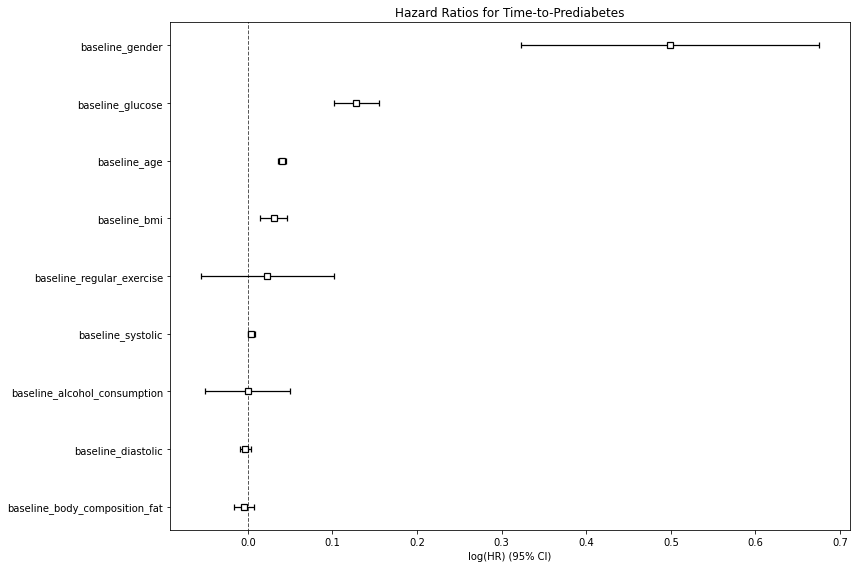


Example risk prediction for a patient:
Baseline characteristics: {'baseline_age': 36.0, 'baseline_gender': 0.0, 'baseline_bmi': 24.095501, 'baseline_glucose': 4.5, 'baseline_systolic': 120.0, 'baseline_diastolic': 74.0, 'baseline_regular_exercise': 1.0, 'baseline_alcohol_consumption': 1.0, 'baseline_body_composition_fat': 30.0}
Risk of developing prediabetes: {'365_days': 0.05883406479635589, '730_days': 0.1124870747997756, '1095_days': 0.24233381762919348}


In [5]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score
import numpy as np
import seaborn as sns
from lifelines import CoxPHFitter
from lifelines.utils import concordance_index

# Time-to-prediabetes forecasting model
import matplotlib.pyplot as plt

# Step 1: Prepare the dataset for time-to-event analysis
# Filter to focus only on patients who were initially not prediabetic
non_prediabetic_initial = df.groupby('patientid').filter(
    lambda x: x.sort_values('assessment_date')['prediabetic'].iloc[0] == 0)

# Create dataset with time between assessments and eventual prediabetes status
survival_data = []

for patient_id, patient_data in non_prediabetic_initial.groupby('patientid'):
    # Sort by assessment date
    patient_data = patient_data.sort_values('assessment_date')
    
    # Find if and when the patient became prediabetic
    prediabetes_onset = patient_data[patient_data['prediabetic'] == 1]
    
    if not prediabetes_onset.empty:
        # Patient developed prediabetes at some point
        first_assessment = patient_data.iloc[0]
        prediabetes_assessment = prediabetes_onset.iloc[0]
        
        days_to_prediabetes = (pd.to_datetime(prediabetes_assessment['assessment_date']) - 
                             pd.to_datetime(first_assessment['assessment_date'])).days
        
        record = {
            'patient_id': patient_id,
            'days_to_prediabetes': days_to_prediabetes,
            'event': 1,  # Event occurred (patient developed prediabetes)
        }
        
        # Add baseline values
        for col in ['age', 'gender', 'bmi', 'glucose', 'systolic', 'diastolic',
                   'regular_exercise', 'alcohol_consumption', 'body_composition_fat']:
            if col in patient_data.columns:
                record[f'baseline_{col}'] = first_assessment[col]
        
        survival_data.append(record)
    
    elif len(patient_data) > 1:
        # Patient didn't develop prediabetes during observation period
        first_assessment = patient_data.iloc[0]
        last_assessment = patient_data.iloc[-1]
        
        observation_time = (pd.to_datetime(last_assessment['assessment_date']) - 
                          pd.to_datetime(first_assessment['assessment_date'])).days
        
        record = {
            'patient_id': patient_id,
            'days_to_prediabetes': observation_time,
            'event': 0,  # No event (censored data)
        }
        
        # Add baseline values
        for col in ['age', 'gender', 'bmi', 'glucose', 'systolic', 'diastolic',
                   'regular_exercise', 'alcohol_consumption', 'body_composition_fat']:
            if col in patient_data.columns:
                record[f'baseline_{col}'] = first_assessment[col]
        
        survival_data.append(record)

survival_df = pd.DataFrame(survival_data)

# Print summary
print(f"Created survival dataset with {len(survival_df)} patients")
print(f"Number who developed prediabetes: {survival_df['event'].sum()}")
print(f"Average time to develop prediabetes: {survival_df[survival_df['event'] == 1]['days_to_prediabetes'].mean():.1f} days")

# Step 2: Create a Cox Proportional Hazards model for survival analysis
cox_columns = [col for col in survival_df.columns 
               if col.startswith('baseline_') and not survival_df[col].isna().any()]

# Fit Cox PH model
cph = CoxPHFitter()
cph.fit(survival_df[cox_columns + ['days_to_prediabetes', 'event']], 
        duration_col='days_to_prediabetes', 
        event_col='event')

# Display model results
print("\nCox Proportional Hazards Model Results:")
cph.print_summary()

# Visualize hazard ratios
plt.figure(figsize=(12, 8))
cph.plot()
plt.title('Hazard Ratios for Time-to-Prediabetes')
plt.tight_layout()
plt.show()

# Create a function to predict risk score for new patients
def predict_prediabetes_risk_over_time(patient_data, time_horizons=[365, 730, 1095]):
    """
    Predict risk of developing prediabetes at different time horizons
    
    Args:
        patient_data: DataFrame with patient baseline characteristics
        time_horizons: List of days for which to predict risk (default: 1, 2, 3 years)
    
    Returns:
        Dictionary of risks at specified time horizons
    """
    # Prepare data in required format
    if not isinstance(patient_data, pd.DataFrame):
        patient_data = pd.DataFrame([patient_data])
    
    # Get required columns only
    required_cols = [col for col in cox_columns if col in patient_data.columns]
    
    # Calculate survival function
    surv_prob = cph.predict_survival_function(patient_data[required_cols])
    
    # Get risk at specified time horizons
    risks = {}
    for days in time_horizons:
        # Find closest time point in the survival function
        try:
            risk = 1 - surv_prob.loc[[days]].values[0][0]
            risks[f"{days}_days"] = risk
        except:
            # If time horizon is beyond what we can predict
            risks[f"{days}_days"] = "Cannot predict that far"
    
    return risks

# Example usage
if len(survival_df) > 0:
    example_patient = survival_df[cox_columns].iloc[0].to_dict()
    print("\nExample risk prediction for a patient:")
    print("Baseline characteristics:", example_patient)
    risk_prediction = predict_prediabetes_risk_over_time(example_patient)
    print("Risk of developing prediabetes:", risk_prediction)

In [8]:
non_prediabetic_initial['patientid'].nunique

<bound method IndexOpsMixin.nunique of 0         0x0001EC929E1AB41684A7B5528628E4B7
1         0x0004022CC26B79C37471E953F521D0DC
5         0x00056BD193D90D603E73CE086364A165
6         0x000602A5DEC68D94EB235D608C2B3A92
7         0x0006690CC0C0661C219D47B8CAAC3D90
                         ...                
117214    0xFFFE9F664C2DDBA4A37BCD35936C7422
117215    0xFFFE9F664C2DDBA4A37BCD35936C7422
117216    0xFFFEF21D8708966769854E3B2EE1D475
117217    0xFFFF41A5B6018F5D524A5CA496301210
117218    0xFFFF79EDF0DA15BF6085A3D7F4BD705F
Name: patientid, Length: 90711, dtype: object>

Model Performance:
              precision    recall  f1-score   support

           0       0.77      0.99      0.87     18018
           1       0.49      0.03      0.06      5348

    accuracy                           0.77     23366
   macro avg       0.63      0.51      0.46     23366
weighted avg       0.71      0.77      0.68     23366

ROC AUC Score: 0.6805


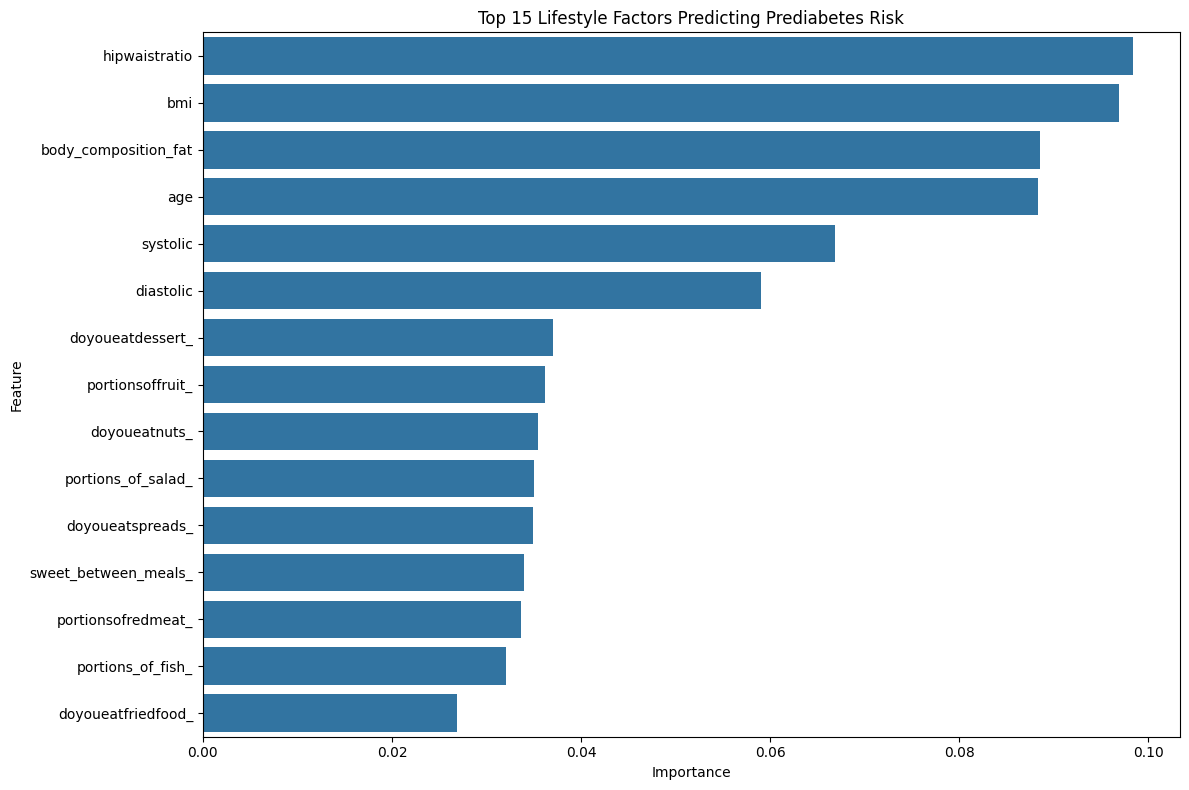


Correlation with Prediabetic Status:
prediabetic                 1.000000
age                         0.217497
hipwaistratio               0.185668
systolic                    0.152704
gender                      0.150740
diastolic                   0.146510
bmi                         0.142592
alcohol_consumption         0.080149
portionsofredmeat_          0.043411
body_composition_fat        0.035218
portions_of_fish_           0.028476
doyoueatspreads_            0.022688
add_sugar_to_food_          0.010077
portionsoffruit_            0.009926
doyoueatfriedfood_          0.004511
doyoueatbreadedfood_        0.000155
doyoueatnuts_              -0.002959
eat_pulses_                -0.004788
eatsaltysnacks_            -0.011803
regular_exercise           -0.013750
eat_oily_fish_             -0.014335
portions_of_salad_         -0.014358
fried_or_breaded_          -0.016094
add_salt_to_food_          -0.023905
doyoueatdessert_           -0.025701
eatfreshorprocessedmeat_   -0.037067


In [5]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix
from sklearn.pipeline import Pipeline
import seaborn as sns
import numpy as np

# Build a risk prediction model for prediabetes using lifestyle data

# Import necessary libraries
import matplotlib.pyplot as plt

# Select lifestyle features and potential risk factors
lifestyle_features = [
    # Self-reported lifestyle data
    'alcohol_consumption', 'regular_exercise',
    'portionsoffruit_', 'portions_of_salad_', 'eat_pulses_', 'portions_of_fish_', 
    'fried_or_breaded_', 'eat_oily_fish_', 'portionsofredmeat_',
    'eatfreshorprocessedmeat_', 'doyoueatspreads_', 'doyoueatfriedfood_', 'doyoueatnuts_',
    'doyoueatbreadedfood_', 'doyoueatdessert_', 'sweet_between_meals_',
    'add_sugar_to_food_', 'add_salt_to_food_', 'eatsaltysnacks_',
    
    # Basic demographic & physical characteristics
    'age', 'gender', 'bmi', 'hipwaistratio', 'body_composition_fat',
    'systolic', 'diastolic'
]

# Filter only valid rows with complete lifestyle data and prediabetes label
# Convert feature columns that might have NaN values to float
for feature in lifestyle_features:
    if feature in df.columns:
        df[feature] = pd.to_numeric(df[feature], errors='coerce')

# Filter rows with valid feature and target data
model_df = df.dropna(subset=lifestyle_features + ['prediabetic'])

# Prepare features and target
X = model_df[lifestyle_features]
y = model_df['prediabetic']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create a pipeline with preprocessing and model
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', RandomForestClassifier(random_state=42, n_estimators=100))
])

# Train the model
pipeline.fit(X_train, y_train)

# Evaluate the model
y_pred = pipeline.predict(X_test)
y_prob = pipeline.predict_proba(X_test)[:, 1]

# Print model performance
print("Model Performance:")
print(classification_report(y_test, y_pred))
print(f"ROC AUC Score: {roc_auc_score(y_test, y_prob):.4f}")

# Feature importance
feature_importance = pd.DataFrame({
    'Feature': lifestyle_features,
    'Importance': pipeline.named_steps['classifier'].feature_importances_
}).sort_values('Importance', ascending=False)

# Plot feature importance
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=feature_importance.head(15))
plt.title('Top 15 Lifestyle Factors Predicting Prediabetes Risk')
plt.tight_layout()
plt.show()

# Calculate correlation between lifestyle features and prediabetic status
correlation = model_df[lifestyle_features + ['prediabetic']].corr()['prediabetic'].sort_values(ascending=False)
print("\nCorrelation with Prediabetic Status:")
print(correlation)

# Create a simple risk score function for new patients
def calculate_prediabetes_risk(patient_data):
    """Calculate prediabetes risk score for a patient based on trained model"""
    if isinstance(patient_data, pd.Series):
        # Convert Series to DataFrame for single prediction
        patient_df = pd.DataFrame([patient_data[lifestyle_features]])
        risk_prob = pipeline.predict_proba(patient_df)[0, 1]
        return risk_prob
    else:
        # For multiple patients in a DataFrame
        risk_probs = pipeline.predict_proba(patient_data[lifestyle_features])[:, 1]
        return risk_probs

print("\nExample risk calculation for first 5 patients in test set:")
example_risks = calculate_prediabetes_risk(X_test.iloc[:5])
print(example_risks)

Number of patients who reversed from prediabetes to normal glucose levels: 2550

Average changes for patients who reversed prediabetes:
age_change                     0.075686
diastolic_change               0.005882
hipwaistratio_change           0.000477
regular_exercise_change        0.000000
alcohol_consumption_change    -0.021176
bmi_change                    -0.078728
body_composition_fat_change   -0.125020
systolic_change               -0.273725
dtype: float64


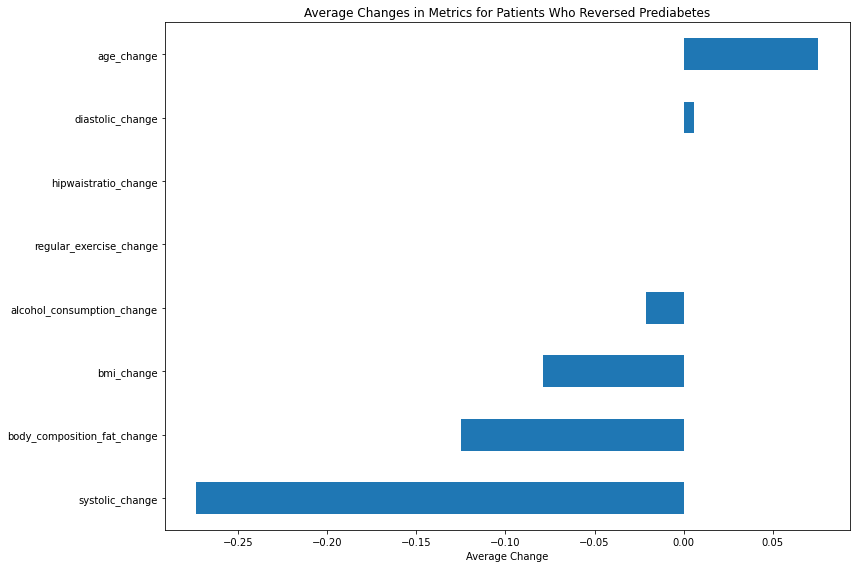

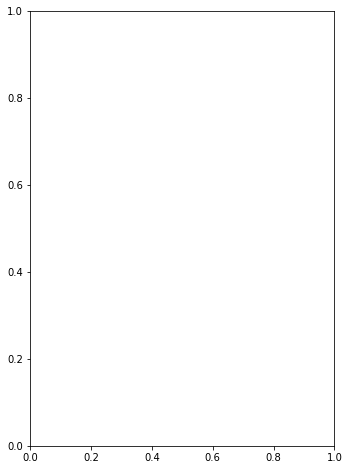

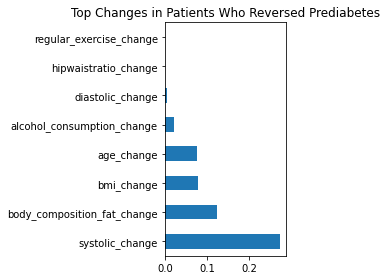

In [11]:
# Identify patients who reversed from prediabetes to normal glucose levels

# Filter patients who have multiple assessments
multiple_assessments = df.groupby('patientid').filter(lambda x: len(x) > 1)

# Create a function to check if a patient went from prediabetic to not prediabetic
def check_reversal(group):
    # Sort by assessment date
    group = group.sort_values('assessment_date')
    # Check if first assessment was prediabetic and last assessment was not prediabetic
    return (group['prediabetic'].iloc[0] == 1) and (group['prediabetic'].iloc[-1] == 0)

# Apply the function to each patient group
prediabetic_reversals = multiple_assessments.groupby('patientid').apply(check_reversal)

# Filter patients who reversed prediabetes
reversed_patients = prediabetic_reversals[prediabetic_reversals].index

# Get the data for these patients
prediabetes_reversal = df[df['patientid'].isin(reversed_patients)].sort_values(['patientid', 'assessment_date'])

# Display the count and patient data
print(f"Number of patients who reversed from prediabetes to normal glucose levels: {len(reversed_patients)}")

# Analyze what factors changed between first and last assessment for patients who reversed prediabetes
reversal_changes = []

for patient_id, patient_data in prediabetes_reversal.groupby('patientid'):
    # Get first and last assessment
    first = patient_data.iloc[0]
    last = patient_data.iloc[-1]
    
    # Calculate changes in key metrics
    changes = {
        'patient_id': patient_id,
        'days_between': (pd.to_datetime(last['assessment_date']) - pd.to_datetime(first['assessment_date'])).days,
        'age_change': last['age'] - first['age']
    }
    
    # Add changes in lifestyle and physical metrics
    for metric in lifestyle_features:
        if metric in patient_data.columns and metric in ['bmi', 'hipwaistratio', 'body_composition_fat', 
                                                       'systolic', 'diastolic', 'regular_exercise',
                                                       'alcohol_consumption']:
            changes[f'{metric}_change'] = last[metric] - first[metric]
            changes[f'{metric}_first'] = first[metric]
            changes[f'{metric}_last'] = last[metric]
    
    reversal_changes.append(changes)

# Create DataFrame with reversal changes
reversal_df = pd.DataFrame(reversal_changes)

# Display the average changes for key metrics
key_metrics = [col for col in reversal_df.columns if '_change' in col]
print("\nAverage changes for patients who reversed prediabetes:")
print(reversal_df[key_metrics].mean().sort_values(ascending=False))

# Visualize the most significant changes
plt.figure(figsize=(12, 8))
reversal_df[key_metrics].mean().sort_values().plot(kind='barh')
plt.title('Average Changes in Metrics for Patients Who Reversed Prediabetes')
plt.xlabel('Average Change')
plt.tight_layout()
plt.show()

# Compare with the feature importance from the prediabetes risk model
plt.figure(figsize=(12, 8))
plt.subplot(1, 2, 1)
feature_importance.head(10).plot(kind='barh', x='Feature', y='Importance')
plt.title('Top Features for Prediabetes Risk')

plt.subplot(1, 2, 2)
reversal_df[key_metrics].mean().abs().sort_values(ascending=False).head(10).plot(kind='barh')
plt.title('Top Changes in Patients Who Reversed Prediabetes')
plt.tight_layout()
plt.show()

In [6]:
# Create a dataset with time-point changes for forecasting

# Get all patients with multiple assessments
patients_with_multiple = df.groupby('patientid').filter(lambda x: len(x) > 1)

# Initialize lists to store data
features = []
targets = []

# Go through each patient
for patient_id, patient_data in patients_with_multiple.groupby('patientid'):
    # Sort by assessment date
    patient_data = patient_data.sort_values('assessment_date')
    
    # Process consecutive pairs of assessments
    for i in range(len(patient_data) - 1):
        current = patient_data.iloc[i]
        next_assessment = patient_data.iloc[i + 1]
        
        # Skip if already prediabetic
        if current['prediabetic'] == 1:
            continue
        
        # Calculate changes in key variables
        changes = {}
        for col in ['weight', 'bmi', 'hipsize', 'waistsize', 'hipwaistratio', 
                    'body_composition_fat', 'systolic', 'diastolic', 'glucose', 
                    'tot_cholesterol', 'age']:
            if col in patient_data.columns:
                changes[f'change_{col}'] = next_assessment[col] - current[col]
        
        # Add baseline values
        for col in ['age', 'gender', 'bmi', 'glucose', 'regular_exercise', 'alcohol_consumption']:
            changes[f'baseline_{col}'] = current[col]
            
        # Add time between assessments
        changes['days_between'] = (pd.to_datetime(next_assessment['assessment_date']) - 
                                   pd.to_datetime(current['assessment_date'])).days
        
        # Target: Did they become prediabetic?
        target = 1 if next_assessment['prediabetic'] == 1 else 0
        
        features.append(changes)
        targets.append(target)

# Create DataFrame with features
features_df = pd.DataFrame(features)
targets_series = pd.Series(targets)

# Check our dataset
print(f"Created dataset with {len(features_df)} assessment pairs")
print(f"Positive cases (transitions to prediabetes): {sum(targets)}")
features_df.head()

Created dataset with 17624 assessment pairs
Positive cases (transitions to prediabetes): 3289


,change_weight,change_bmi,change_hipsize,change_waistsize,change_hipwaistratio,change_body_composition_fat,change_systolic,change_diastolic,change_glucose,change_tot_cholesterol,change_age,baseline_age,baseline_gender,baseline_bmi,baseline_glucose,baseline_regular_exercise,baseline_alcohol_consumption,days_between
0,0.7,0.257116,-10.0,3.0,0.109774,0.3,10,0,-0.1,0.2,2,36,0,24.095501,4.5,1,1,734
1,-0.1,0.260708,6.0,-3.0,-0.080354,-2.3,-30,-2,0.1,0.4,-1,38,0,24.352617,4.4,1,1,-385
2,-0.5,-0.481092,-3.0,-0.5,0.018539,2.3,22,-2,0.6,-0.5,-2,37,0,24.613325,4.5,1,1,-727
3,-0.1,-0.310427,-2.0,4.0,0.059406,-1.8,-8,0,0.1,0.6,-1,60,1,25.059967,5.0,1,2,-385
4,1.5,0.457861,0.0,4.0,0.040000,-0.6,-3,6,0.3,0.2,2,44,1,23.534082,5.2,1,2,740


In [ ]:
# features_df

,change_weight,change_bmi,change_hipsize,change_waistsize,change_hipwaistratio,change_body_composition_fat,change_systolic,change_diastolic,change_glucose,change_tot_cholesterol,change_age,baseline_age,baseline_gender,baseline_bmi,baseline_glucose,baseline_regular_exercise,baseline_alcohol_consumption,days_between
0,0.7,0.257116,-10.0,3.0,0.109774,0.3,10,0,-0.1,0.20,2,36,0,24.095501,4.5,1,1,734
1,-0.1,0.260708,6.0,-3.0,-0.080354,-2.3,-30,-2,0.1,0.40,-1,38,0,24.352617,4.4,1,1,-385
2,-0.5,-0.481092,-3.0,-0.5,0.018539,2.3,22,-2,0.6,-0.50,-2,37,0,24.613325,4.5,1,1,-727
3,-0.1,-0.310427,-2.0,4.0,0.059406,-1.8,-8,0,0.1,0.60,-1,60,1,25.059967,5.0,1,2,-385
4,1.5,0.457861,0.0,4.0,0.040000,-0.6,-3,6,0.3,0.20,2,44,1,23.534082,5.2,1,2,740
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17619,-0.8,-0.297442,2.0,-1.0,-0.029952,-2.3,-10,-6,0.2,1.50,2,47,1,24.167162,5.4,1,1,773
17620,3.3,1.007295,-3.5,-3.0,0.001554,2.3,-8,-6,0.4,1.24,2,58,1,21.702635,4.2,1,1,766
17621,-2.1,-0.641006,0.0,-1.0,-0.010363,-0.8,-3,8,-0.2,-1.29,-1,60,1,22.709930,4.6,0,1,-354
17622,1.5,0.178171,-3.0,-2.0,0.004501,-0.9,-10,0,-0.2,-0.50,-1,26,1,28.021902,4.7,1,1,-363


In [8]:
# Filter patients who have multiple assessments
multiple_assessments = df.groupby('patientid').filter(lambda x: len(x) > 1)

# Create a function to check if a patient went from not prediabetic to prediabetic
def check_transition(group):
    # Sort by assessment date
    group = group.sort_values('assessment_date')
    # Check if first assessment was not prediabetic and last assessment was prediabetic
    return (group['prediabetic'].iloc[0] == 0) and (group['prediabetic'].iloc[-1] == 1)

# Apply the function to each patient group
prediabetic_transitions = multiple_assessments.groupby('patientid').apply(check_transition)

# Filter patients who transitioned
transitioned_patients = prediabetic_transitions[prediabetic_transitions].index

# Get the data for these patients
prediabetes_progression = df[df['patientid'].isin(transitioned_patients)].sort_values(['patientid', 'assessment_date'])

# Display the count and patient data
print(f"Number of patients who went from not having prediabetes to having prediabetes: {len(transitioned_patients)}")
prediabetes_progression

Number of patients who went from not having prediabetes to having prediabetes: 2565


,patientid,healthassessmentid,assessment_date,n_assessment,assessment_number,final_assessment,assessment_year,assessment_type,assessment_quarter,assessment_month,...,imd_idaopi_score,glucose,tot_cholesterol,alcohol_consumption,regular_exercise,t2dm_nice,prediabetic,first_to_last,days_between_ha,years_between_ha
34,0x0014CB06991F127CC91B006823AD9726,0x3640DD43418647144D78EFD4B9BFD659,10dec2014,2,1,0,2014,4,4,12,...,0.191,5.2,4.00,2,1,0,0,NaN,NaN,NaN
35,0x0014CB06991F127CC91B006823AD9726,0x39CA627C758A0EED8BE9717D0C88A9B3,19dec2016,2,2,1,2016,3,4,12,...,0.191,5.5,4.20,1,0,0,1,2.0,740.0,2.0
165,0x0066C9097D9BD3BD0EE283DD087E23B5,0x225D0F0E973D16355A50816445804410,07dec2016,2,1,0,2016,3,4,12,...,0.066,5.3,6.70,2,1,0,0,NaN,NaN,NaN
166,0x0066C9097D9BD3BD0EE283DD087E23B5,0xF29BFC22BC35784D66EB449E3F24B21B,12mar2018,2,2,1,2018,3,1,3,...,0.066,5.6,6.90,2,1,0,1,1.0,460.0,1.0
361,0x00D84A27CDC52F77B5010272BA916675,0xD58FCCC4F256FCC1EBE305D9A47BD54B,24mar2016,2,1,0,2016,1,1,3,...,0.072,4.9,5.19,1,0,0,0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
117080,0xFF9D3A3258DFB85307D3110C534C9B57,0x91D0B897155A4D6390C6D5E8ED174901,22mar2016,2,1,0,2016,4,1,3,...,0.146,6.4,6.00,2,1,0,1,NaN,NaN,NaN
117102,0xFFAAD96EE841D318280B7616BD3B06CB,0x9B20928E594EEAF2720A067394A9912B,14aug2014,2,1,0,2014,1,3,8,...,0.039,5.3,5.70,1,0,0,0,NaN,NaN,NaN
117103,0xFFAAD96EE841D318280B7616BD3B06CB,0x3242DAC719090336CB37BF90D3B09456,27jun2016,2,2,1,2016,1,2,6,...,0.039,5.7,7.50,1,0,0,1,2.0,683.0,2.0
117147,0xFFD0C2E38B14DF2845BC012F8D52F442,0xC036D91963D26720D57CED9EC04171A3,04nov2016,2,2,1,2016,3,4,11,...,0.086,6.0,5.40,1,1,0,0,2.0,801.0,2.0
